In [201]:
from sklearn.model_selection import GroupKFold, cross_val_score, KFold
from sklearn.cross_decomposition import PLSRegression
from sklearn.metrics import make_scorer, mean_squared_error, confusion_matrix, ConfusionMatrixDisplay
import numpy as np
import os, glob, re, json
from os.path import join
import numpy as np
import pandas as pd
from nilearn import image, masking, maskers, plotting
from nilearn.image import resample_to_img, math_img, new_img_like
from datetime import datetime
import nibabel as nib
import matplotlib.pyplot as plt
import seaborn as sns
import joblib
import h5py


In [143]:
from functools import reduce

import numpy as np

from ...base import is_regressor
from ...preprocessing import LabelEncoder
from ...utils import _safe_indexing, check_matplotlib_support
from ...utils.validation import (
    _is_arraylike_not_scalar,
    _num_features,
    check_is_fitted,
)


def _check_boundary_response_method(estimator, response_method):
    """Return prediction method from the `response_method` for decision boundary.

    Parameters
    ----------
    estimator : object
        Fitted estimator to check.

    response_method : {'auto', 'predict_proba', 'decision_function', 'predict'}
        Specifies whether to use :term:`predict_proba`,
        :term:`decision_function`, :term:`predict` as the target response.
        If set to 'auto', the response method is tried in the following order:
        :term:`decision_function`, :term:`predict_proba`, :term:`predict`.

    Returns
    -------
    prediction_method: callable
        Prediction method of estimator.
    """
    has_classes = hasattr(estimator, "classes_")
    if has_classes and _is_arraylike_not_scalar(estimator.classes_[0]):
        msg = "Multi-label and multi-output multi-class classifiers are not supported"
        raise ValueError(msg)

    if has_classes and len(estimator.classes_) > 2:
        if response_method not in {"auto", "predict"}:
            msg = (
                "Multiclass classifiers are only supported when response_method is"
                " 'predict' or 'auto'"
            )
            raise ValueError(msg)
        methods_list = ["predict"]
    elif response_method == "auto":
        methods_list = ["decision_function", "predict_proba", "predict"]
    else:
        methods_list = [response_method]

    prediction_method = [getattr(estimator, method, None) for method in methods_list]
    prediction_method = reduce(lambda x, y: x or y, prediction_method)
    if prediction_method is None:
        raise ValueError(
            f"{estimator.__class__.__name__} has none of the following attributes: "
            f"{', '.join(methods_list)}."
        )

    return prediction_method


class DecisionBoundaryDisplay:
    """Decisions boundary visualization.

    It is recommended to use
    :func:`~sklearn.inspection.DecisionBoundaryDisplay.from_estimator`
    to create a :class:`DecisionBoundaryDisplay`. All parameters are stored as
    attributes.

    Read more in the :ref:`User Guide <visualizations>`.

    .. versionadded:: 1.1

    Parameters
    ----------
    xx0 : ndarray of shape (grid_resolution, grid_resolution)
        First output of :func:`meshgrid <numpy.meshgrid>`.

    xx1 : ndarray of shape (grid_resolution, grid_resolution)
        Second output of :func:`meshgrid <numpy.meshgrid>`.

    response : ndarray of shape (grid_resolution, grid_resolution)
        Values of the response function.

    xlabel : str, default=None
        Default label to place on x axis.

    ylabel : str, default=None
        Default label to place on y axis.

    Attributes
    ----------
    surface_ : matplotlib `QuadContourSet` or `QuadMesh`
        If `plot_method` is 'contour' or 'contourf', `surface_` is a
        :class:`QuadContourSet <matplotlib.contour.QuadContourSet>`. If
        `plot_method` is 'pcolormesh', `surface_` is a
        :class:`QuadMesh <matplotlib.collections.QuadMesh>`.

    ax_ : matplotlib Axes
        Axes with confusion matrix.

    figure_ : matplotlib Figure
        Figure containing the confusion matrix.

    See Also
    --------
    DecisionBoundaryDisplay.from_estimator : Plot decision boundary given an estimator.

    Examples
    --------
    >>> import matplotlib.pyplot as plt
    >>> import numpy as np
    >>> from sklearn.datasets import load_iris
    >>> from sklearn.inspection import DecisionBoundaryDisplay
    >>> from sklearn.tree import DecisionTreeClassifier
    >>> iris = load_iris()
    >>> feature_1, feature_2 = np.meshgrid(
    ...     np.linspace(iris.data[:, 0].min(), iris.data[:, 0].max()),
    ...     np.linspace(iris.data[:, 1].min(), iris.data[:, 1].max())
    ... )
    >>> grid = np.vstack([feature_1.ravel(), feature_2.ravel()]).T
    >>> tree = DecisionTreeClassifier().fit(iris.data[:, :2], iris.target)
    >>> y_pred = np.reshape(tree.predict(grid), feature_1.shape)
    >>> display = DecisionBoundaryDisplay(
    ...     xx0=feature_1, xx1=feature_2, response=y_pred
    ... )
    >>> display.plot()
    <...>
    >>> display.ax_.scatter(
    ...     iris.data[:, 0], iris.data[:, 1], c=iris.target, edgecolor="black"
    ... )
    <...>
    >>> plt.show()
    """

    def __init__(self, *, xx0, xx1, response, xlabel=None, ylabel=None):
        self.xx0 = xx0
        self.xx1 = xx1
        self.response = response
        self.xlabel = xlabel
        self.ylabel = ylabel

    def plot(self, plot_method="contourf", ax=None, xlabel=None, ylabel=None, **kwargs):
        """Plot visualization.

        Parameters
        ----------
        plot_method : {'contourf', 'contour', 'pcolormesh'}, default='contourf'
            Plotting method to call when plotting the response. Please refer
            to the following matplotlib documentation for details:
            :func:`contourf <matplotlib.pyplot.contourf>`,
            :func:`contour <matplotlib.pyplot.contour>`,
            :func:`pcolormesh <matplotlib.pyplot.pcolormesh>`.

        ax : Matplotlib axes, default=None
            Axes object to plot on. If `None`, a new figure and axes is
            created.

        xlabel : str, default=None
            Overwrite the x-axis label.

        ylabel : str, default=None
            Overwrite the y-axis label.

        **kwargs : dict
            Additional keyword arguments to be passed to the `plot_method`.

        Returns
        -------
        display: :class:`~sklearn.inspection.DecisionBoundaryDisplay`
            Object that stores computed values.
        """
        check_matplotlib_support("DecisionBoundaryDisplay.plot")
        import matplotlib.pyplot as plt  # noqa

        if plot_method not in ("contourf", "contour", "pcolormesh"):
            raise ValueError(
                "plot_method must be 'contourf', 'contour', or 'pcolormesh'"
            )

        if ax is None:
            _, ax = plt.subplots()

        plot_func = getattr(ax, plot_method)
        self.surface_ = plot_func(self.xx0, self.xx1, self.response, **kwargs)

        if xlabel is not None or not ax.get_xlabel():
            xlabel = self.xlabel if xlabel is None else xlabel
            ax.set_xlabel(xlabel)
        if ylabel is not None or not ax.get_ylabel():
            ylabel = self.ylabel if ylabel is None else ylabel
            ax.set_ylabel(ylabel)

        self.ax_ = ax
        self.figure_ = ax.figure
        return self

    @classmethod
    def from_estimator(
        cls,
        estimator,
        X,
        *,
        grid_resolution=100,
        eps=1.0,
        plot_method="contourf",
        response_method="auto",
        xlabel=None,
        ylabel=None,
        ax=None,
        **kwargs,
    ):
        """Plot decision boundary given an estimator.

        Read more in the :ref:`User Guide <visualizations>`.

        Parameters
        ----------
        estimator : object
            Trained estimator used to plot the decision boundary.

        X : {array-like, sparse matrix, dataframe} of shape (n_samples, 2)
            Input data that should be only 2-dimensional.

        grid_resolution : int, default=100
            Number of grid points to use for plotting decision boundary.
            Higher values will make the plot look nicer but be slower to
            render.

        eps : float, default=1.0
            Extends the minimum and maximum values of X for evaluating the
            response function.

        plot_method : {'contourf', 'contour', 'pcolormesh'}, default='contourf'
            Plotting method to call when plotting the response. Please refer
            to the following matplotlib documentation for details:
            :func:`contourf <matplotlib.pyplot.contourf>`,
            :func:`contour <matplotlib.pyplot.contour>`,
            :func:`pcolormesh <matplotlib.pyplot.pcolormesh>`.

        response_method : {'auto', 'predict_proba', 'decision_function', \
                'predict'}, default='auto'
            Specifies whether to use :term:`predict_proba`,
            :term:`decision_function`, :term:`predict` as the target response.
            If set to 'auto', the response method is tried in the following order:
            :term:`decision_function`, :term:`predict_proba`, :term:`predict`.
            For multiclass problems, :term:`predict` is selected when
            `response_method="auto"`.

        xlabel : str, default=None
            The label used for the x-axis. If `None`, an attempt is made to
            extract a label from `X` if it is a dataframe, otherwise an empty
            string is used.

        ylabel : str, default=None
            The label used for the y-axis. If `None`, an attempt is made to
            extract a label from `X` if it is a dataframe, otherwise an empty
            string is used.

        ax : Matplotlib axes, default=None
            Axes object to plot on. If `None`, a new figure and axes is
            created.

        **kwargs : dict
            Additional keyword arguments to be passed to the
            `plot_method`.

        Returns
        -------
        display : :class:`~sklearn.inspection.DecisionBoundaryDisplay`
            Object that stores the result.

        See Also
        --------
        DecisionBoundaryDisplay : Decision boundary visualization.
        sklearn.metrics.ConfusionMatrixDisplay.from_estimator : Plot the
            confusion matrix given an estimator, the data, and the label.
        sklearn.metrics.ConfusionMatrixDisplay.from_predictions : Plot the
            confusion matrix given the true and predicted labels.

        Examples
        --------
        >>> import matplotlib.pyplot as plt
        >>> from sklearn.datasets import load_iris
        >>> from sklearn.linear_model import LogisticRegression
        >>> from sklearn.inspection import DecisionBoundaryDisplay
        >>> iris = load_iris()
        >>> X = iris.data[:, :2]
        >>> classifier = LogisticRegression().fit(X, iris.target)
        >>> disp = DecisionBoundaryDisplay.from_estimator(
        ...     classifier, X, response_method="predict",
        ...     xlabel=iris.feature_names[0], ylabel=iris.feature_names[1],
        ...     alpha=0.5,
        ... )
        >>> disp.ax_.scatter(X[:, 0], X[:, 1], c=iris.target, edgecolor="k")
        <...>
        >>> plt.show()
        """
        check_matplotlib_support(f"{cls.__name__}.from_estimator")
        check_is_fitted(estimator)

        if not grid_resolution > 1:
            raise ValueError(
                "grid_resolution must be greater than 1. Got"
                f" {grid_resolution} instead."
            )

        if not eps >= 0:
            raise ValueError(
                f"eps must be greater than or equal to 0. Got {eps} instead."
            )

        possible_plot_methods = ("contourf", "contour", "pcolormesh")
        if plot_method not in possible_plot_methods:
            available_methods = ", ".join(possible_plot_methods)
            raise ValueError(
                f"plot_method must be one of {available_methods}. "
                f"Got {plot_method} instead."
            )

        num_features = _num_features(X)
        if num_features != 2:
            raise ValueError(
                f"n_features must be equal to 2. Got {num_features} instead."
            )

        x0, x1 = _safe_indexing(X, 0, axis=1), _safe_indexing(X, 1, axis=1)

        x0_min, x0_max = x0.min() - eps, x0.max() + eps
        x1_min, x1_max = x1.min() - eps, x1.max() + eps

        xx0, xx1 = np.meshgrid(
            np.linspace(x0_min, x0_max, grid_resolution),
            np.linspace(x1_min, x1_max, grid_resolution),
        )
        if hasattr(X, "iloc"):
            # we need to preserve the feature names and therefore get an empty dataframe
            X_grid = X.iloc[[], :].copy()
            X_grid.iloc[:, 0] = xx0.ravel()
            X_grid.iloc[:, 1] = xx1.ravel()
        else:
            X_grid = np.c_[xx0.ravel(), xx1.ravel()]

        pred_func = _check_boundary_response_method(estimator, response_method)
        response = pred_func(X_grid)

        # convert classes predictions into integers
        if pred_func.__name__ == "predict" and hasattr(estimator, "classes_"):
            encoder = LabelEncoder()
            encoder.classes_ = estimator.classes_
            response = encoder.transform(response)

        if response.ndim != 1:
            if is_regressor(estimator):
                raise ValueError("Multi-output regressors are not supported")

            # TODO: Support pos_label
            response = response[:, 1]

        if xlabel is None:
            xlabel = X.columns[0] if hasattr(X, "columns") else ""

        if ylabel is None:
            ylabel = X.columns[1] if hasattr(X, "columns") else ""

        display = DecisionBoundaryDisplay(
            xx0=xx0,
            xx1=xx1,
            response=response.reshape(xx0.shape),
            xlabel=xlabel,
            ylabel=ylabel,
        )
        return display.plot(ax=ax, plot_method=plot_method, **kwargs)

ImportError: attempted relative import with no known parent package

## load brain behavioral

In [2]:
braindf_fname = '/dartfs-hpc/rc/lab/C/CANlab/labdata/projects/spacetop_projects_cue/analysis/fmri/nilearn/pls/singletrial_pvc.h5'
behdf_fname = '//dartfs-hpc/rc/lab/C/CANlab/labdata/projects/spacetop_projects_cue/analysis/fmri/nilearn/pls/singletrial_pvc.csv'

with h5py.File(braindf_fname, 'r') as hdf:
    braindf = hdf['singletrial'][:]

behdf = pd.read_csv(behdf_fname)

In [243]:
Y_strat

array([0, 0, 0, ..., 2, 2, 2])

In [242]:
Y_strat = pd.factorize(behdf['runtype'])[0]
X_strat = braindf  
# create groups (per subject)
codes, _ = pd.factorize(behdf['sub'])
behdf['groupsinterim'] = codes + 1
groups = behdf['groupsinterim']

In [222]:
np.unique(behdf['sub'])

array(['sub-0002', 'sub-0003', 'sub-0004', 'sub-0005', 'sub-0006',
       'sub-0007', 'sub-0008', 'sub-0009', 'sub-0010', 'sub-0011',
       'sub-0013', 'sub-0014', 'sub-0015', 'sub-0016', 'sub-0017',
       'sub-0018', 'sub-0019', 'sub-0021', 'sub-0023', 'sub-0024',
       'sub-0025', 'sub-0026', 'sub-0028', 'sub-0029', 'sub-0030',
       'sub-0031', 'sub-0032', 'sub-0033', 'sub-0035', 'sub-0036',
       'sub-0037', 'sub-0038', 'sub-0039', 'sub-0040', 'sub-0041',
       'sub-0043', 'sub-0044', 'sub-0047', 'sub-0050', 'sub-0051',
       'sub-0052', 'sub-0053', 'sub-0055', 'sub-0056', 'sub-0057',
       'sub-0058', 'sub-0059', 'sub-0060', 'sub-0061', 'sub-0062',
       'sub-0063', 'sub-0064', 'sub-0066', 'sub-0068', 'sub-0069',
       'sub-0070', 'sub-0071', 'sub-0073', 'sub-0074', 'sub-0075',
       'sub-0076', 'sub-0077', 'sub-0078', 'sub-0079', 'sub-0080',
       'sub-0081', 'sub-0082', 'sub-0083', 'sub-0084', 'sub-0085',
       'sub-0086', 'sub-0087', 'sub-0088', 'sub-0089', 'sub-00

In [239]:
subset_beh.head()

,basename,onset,duration,trial_type,sub,ses,run,runtype,eventtype,trialnum,...,stimtype,expectrating,outcomerating,singletrial_fname,singletrial_fname_no_ext,pain_cue,vic_cue,cog_cue,gen_cue,groupsinterim
16440,sub-0060_ses-01_run-01_runtype-pain_event-cue_...,4.70314,1.0,cue,sub-0060,ses-01,run-01,pain,cue,0,...,low_stim,NaN,NaN,sub-0060_ses-01_run-01_runtype-pain_event-cue_...,sub-0060_ses-01_run-01_runtype-pain_event-cue_...,1,0,0,1,48
16441,sub-0060_ses-01_run-01_runtype-pain_event-cue_...,32.99702,1.0,cue,sub-0060,ses-01,run-01,pain,cue,1,...,low_stim,NaN,NaN,sub-0060_ses-01_run-01_runtype-pain_event-cue_...,sub-0060_ses-01_run-01_runtype-pain_event-cue_...,-1,0,0,-1,48
16442,sub-0060_ses-01_run-01_runtype-pain_event-cue_...,58.00635,1.0,cue,sub-0060,ses-01,run-01,pain,cue,2,...,med_stim,NaN,NaN,sub-0060_ses-01_run-01_runtype-pain_event-cue_...,sub-0060_ses-01_run-01_runtype-pain_event-cue_...,-1,0,0,-1,48
16443,sub-0060_ses-01_run-01_runtype-pain_event-cue_...,83.39915,1.0,cue,sub-0060,ses-01,run-01,pain,cue,3,...,high_stim,0.000000,NaN,sub-0060_ses-01_run-01_runtype-pain_event-cue_...,sub-0060_ses-01_run-01_runtype-pain_event-cue_...,-1,0,0,-1,48
16444,sub-0060_ses-01_run-01_runtype-pain_event-cue_...,115.81124,1.0,cue,sub-0060,ses-01,run-01,pain,cue,4,...,med_stim,51.017503,NaN,sub-0060_ses-01_run-01_runtype-pain_event-cue_...,sub-0060_ses-01_run-01_runtype-pain_event-cue_...,1,0,0,1,48


## model ver 1

In [ ]:
from sklearn.svm import SVC
from sklearn.model_selection import cross_val_score, GroupKFold
import numpy as np

# Initialize a dictionary to store cross-validation scores per participant
participant_scores = {}
outer_cv = GroupKFold(n_splits=10)
# Outer loop for participants
# for i, sub_id in enumerate(np.unique(behdf['sub'])):
for i, (train_idx, test_idx) in enumerate(outer_cv.split(X, Y, groups)):
    participant_id = i
    subset_beh = behdf[behdf['sub'] == sub_id]
    participant_images = braindf[subset_beh.index]
    participant_labels = subset_beh['runtype']
    
    # Define the inner cross-validation
    inner_cv = GroupKFold(n_splits=5)  # You can adjust the number of folds
    
    # Initialize your Linear SVM model
    model = SVC(kernel='linear', class_weight='balanced')  # Linear SVM
    
    # Perform cross-validation within the participant
    scores = cross_val_score(model, participant_images, participant_labels, cv=inner_cv, groups=participant_labels)
    
    # Store the cross-validation scores for this participant
    participant_scores[participant_id] = scores

# Now you have the cross-validation scores per participant in participant_scores
# You can calculate the mean and standard deviation of scores for each participant as needed


## model ver 2

In [ ]:
import numpy as np
from sklearn.model_selection import StratifiedKFold
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score

# This code essentially performs 10-fold cross-validation with a Support Vector Machine classifier to evaluate the model's performance on the given brain data and labels, ensuring that the cross-validation process is stratified and group-wise. The mean accuracy provides an estimate of how well the SVM model generalizes to unseen data.
# # X: brain data. shape: (number of trials, number of voxels)
# # Y: 1D array with labels (0 for pain, 1 for vicarious, 2 for cognitive)

# 10-fold stratified cross validation
# folds are applied on subject level data
# A linear SVM classifer is trained on the training data and applied on the test data, by predicting the labels on the test data.
# accuracies compiles the model accuracy of predicting the labels across the 10 folds. 


# Initialize arrays to store results
accuracies = []

# Loop through each fold

import time
start_time = time.perf_counter()
outer_cv = GroupKFold(n_splits=10)
# pls_model = PLSRegression(n_components=3)
i = 0
scores = []
weights_per_fold = []
coefficients = []
yloadings = []
Y = Y_strat
X = X_strat
for i, (train_idx, test_idx) in enumerate(outer_cv.split(X, Y, groups)):
    X_train, X_test = X[train_idx], X[test_idx]
    Y_train, Y_test = Y[train_idx], Y[test_idx]
    
    # Initialize and train a Support Vector Machine (SVM) classifier
    svm = SVC(kernel='linear', class_weight='balanced', decision_function_shape='ovr')  # One-vs-Rest
    svm.fit(X_train, Y_train)
    
    # Predict using the trained model
    Y_pred = svm.predict(X_test)
    
    # Calculate accuracy for this fold
    accuracy = accuracy_score(Y_test, Y_pred)
    accuracies.append(accuracy)

# Calculate the mean accuracy across all folds
mean_accuracy = np.mean(accuracies)

# Display the mean accuracy
print(f"Mean Accuracy: {mean_accuracy * 100:.2f}%")
end_time = time.perf_counter()
elapsed_time = end_time - start_time
print(f"Elapsed time: {elapsed_time} seconds")


## visualization

In [ ]:
from sklearn.metrics import roc_curve, auc
import matplotlib.pyplot as plt

# Assuming Y_test and Y_pred are the true labels and predicted labels
fpr = dict()
tpr = dict()
roc_auc = dict()

# Calculate ROC curve and AUC for each class
for i in range(num_classes):
    fpr[i], tpr[i], _ = roc_curve(Y_test == i, Y_pred == i)
    roc_auc[i] = auc(fpr[i], tpr[i])

# Plot ROC curves for each class
plt.figure()
colors = ['blue', 'red', 'green']  # Adjust colors as needed
for i in range(num_classes):
    plt.plot(fpr[i], tpr[i], color=colors[i], lw=2, label=f'Class {i} (AUC = {roc_auc[i]:.2f})')

plt.plot([0, 1], [0, 1], color='gray', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic')
plt.legend(loc='lower right')
plt.show()


In [ ]:
import numpy as np

# Add jitter to Y_pred for visualization
jitter = np.random.uniform(-0.1, 0.1, size=len(Y_pred))
Y_pred_jittered = Y_pred + jitter

plt.scatter(Y, Y_pred_jittered, alpha=0.5)
plt.xlabel('True Labels (Y)')
plt.ylabel('Predicted Labels (Y_pred)')
plt.title('True vs. Predicted Labels')
plt.show()


In [ ]:
## 3) brain maps
import numpy as np

# Add jitter to Y_pred for visualization
jitter = np.random.uniform(-0.1, 0.1, size=len(Y_pred))
Y_pred_jittered = Y_pred + jitter

plt.scatter(Y, Y_pred_jittered, alpha=0.5)
plt.xlabel('True Labels (Y)')
plt.ylabel('Predicted Labels (Y_pred)')
plt.title('True vs. Predicted Labels')
plt.show()


# classification using contrast maps per subject

In [6]:
# load contrast maps
# - 13. simple_stim_P: stimulus epoch, pain runs > baseline
# - 14. simple_stim_V: stimulus epoch, vicarious runs > baseline
# - 15. simple_stim_C: stimulus epoch, cognitive runs > baseline
# 'sub-0041_con_0013.nii'
# 'sub-0041_con_0014.nii'
# 'sub-0041_con_0015.nii'

# load nifti and stack
# label pain vaicarious cognitive


con_dir = '/dartfs-hpc/rc/lab/C/CANlab/labdata/projects/spacetop_projects_cue/analysis/fmri/spm/univariate/model02_CESO/1stlevel/'
pain_list = sorted(glob.glob(join(con_dir, 'sub-*', "*_con_0013.nii")))
vic_list = sorted(glob.glob(join(con_dir, 'sub-*', "*_con_0014.nii")))
cog_list = sorted(glob.glob(join(con_dir, 'sub-*', "*_con_0015.nii")))



In [9]:

pain_load = [image.load_img(f) for f in pain_list]
pain_image = image.concat_imgs(pain_load)

vic_load = [image.load_img(f) for f in vic_list]
vic_image = image.concat_imgs(vic_load)

cog_load = [image.load_img(f) for f in cog_list]
cog_image = image.concat_imgs(cog_load)


In [33]:
imgfname = "/dartfs-hpc/rc/lab/C/CANlab/labdata/projects/spacetop_projects_cue/analysis/fmri/nilearn/singletrial/sub-0060/sub-0060_ses-01_run-05_runtype-vicarious_event-stimulus_trial-011_cuetype-low_stimintensity-low.nii.gz"
ref_img = image.load_img(imgfname)
mask = image.load_img(
    "/dartfs-hpc/rc/lab/C/CANlab/modules/CanlabCore/CanlabCore/canlab_canonical_brains/Canonical_brains_surfaces/brainmask_canlab.nii"
)
mask_img = masking.compute_epi_mask(
    mask, target_affine=ref_img.affine, target_shape=ref_img.shape
)


# Apply the mask using NiftiMasker
nifti_masker = maskers.NiftiMasker(
    mask_img=mask_img,
    smoothing_fwhm=6,
    target_affine=ref_img.affine,
    target_shape=ref_img.shape,
)

masked_pain = nifti_masker.fit_transform(pain_image)
masked_vic = nifti_masker.fit_transform(vic_image)
masked_cog = nifti_masker.fit_transform(cog_image)
X = np.concatenate([masked_pain, masked_vic, masked_cog])
print(X.shape)

(285, 98053)


In [79]:
pain_array = np.full((masked_pain.shape[0],), 'pain', dtype='str')
vic_array = np.full((masked_vic.shape[0],), 'vicarious', dtype='str')
cog_array = np.full((masked_cog.shape[0],), 'cognitive', dtype='str')
Ylabels = np.concatenate([pain_array, vic_array, cog_array])
print(Ylabels.shape)

group = np.concatenate([np.arange(masked_pain.shape[0] )+1, np.arange(masked_vic.shape[0])+1, np.arange(masked_cog.shape[0])+1])
group
print(group.shape)

(285,)
(285,)


In [80]:
group

array([ 1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16, 17,
       18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34,
       35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51,
       52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68,
       69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 83, 84, 85,
       86, 87, 88, 89, 90, 91, 92, 93, 94, 95,  1,  2,  3,  4,  5,  6,  7,
        8,  9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24,
       25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41,
       42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58,
       59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 71, 72, 73, 74, 75,
       76, 77, 78, 79, 80, 81, 82, 83, 84, 85, 86, 87, 88, 89, 90, 91, 92,
       93, 94, 95,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14,
       15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31,
       32, 33, 34, 35, 36

In [81]:
from sklearn.preprocessing import LabelEncoder

# Create a LabelEncoder instance
label_encoder = LabelEncoder()

# Fit the LabelEncoder to your labels and transform them into numerical values
Y = label_encoder.fit_transform(Ylabels)

# Print the converted numerical labels
print(Y)


[1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2
 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2
 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2
 2 2 2 2 2 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]


In [152]:
import numpy as np


# Define a mapping from string values to numerical values
mapping = {'p': 0, 'v': 1, 'c': 2}

# Use NumPy's vectorized operation to perform the conversion
Y = np.array([mapping[value] for value in Ylabels])

# The 'numerical_array' now contains numerical values
print(Y)


[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2
 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2
 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2]


## model

In [198]:
import numpy as np
from sklearn.model_selection import StratifiedKFold
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score

# This code essentially performs 10-fold cross-validation with a Support Vector Machine classifier to evaluate the model's performance on the given brain data and labels, ensuring that the cross-validation process is stratified and group-wise. The mean accuracy provides an estimate of how well the SVM model generalizes to unseen data.
# # X: brain data. shape: (number of trials, number of voxels)
# # Y: 1D array with labels (0 for pain, 1 for vicarious, 2 for cognitive)

# 10-fold stratified cross validation
# folds are applied on subject level data
# A linear SVM classifer is trained on the training data and applied on the test data, by predicting the labels on the test data.
# accuracies compiles the model accuracy of predicting the labels across the 10 folds. 


# Initialize arrays to store results
accuracies = []

# Loop through each fold

import time
start_time = time.perf_counter()
crossval = GroupKFold(n_splits=10)
# pls_model = PLSRegression(n_components=3)
i = 0
scores = []
weights_per_fold = []
coefficients = []
yloadings = []
confusion_matrices = []


# Y = Yinterim
for i, (train_idx, test_idx) in enumerate(crossval.split(X, Y, group)):
    X_train, X_test = X[train_idx], X[test_idx]
    Y_train, Y_test = Y[train_idx], Y[test_idx]
    
    # Initialize and train a Support Vector Machine (SVM) classifier
    svm = SVC(kernel='linear', decision_function_shape='ovr')  # One-vs-Rest
    svm.fit(X_train, Y_train)
    
    
    # Predict using the trained model
    Y_pred = svm.predict(X_test)
    
    # Calculate accuracy for this fold
    accuracy = accuracy_score(Y_test, Y_pred)
    accuracies.append(accuracy)
    
    # confusion matrix
    cm = confusion_matrix(Y_test, Y_pred)
    confusion_matrices.append(cm)

    # Extract coefficients
    coef = svm.coef_ #dual_coef_
    coefficients.append(coef)
    
# Calculate the mean accuracy across all folds
mean_accuracy = np.mean(accuracies)

# Display the mean accuracy
print(f"Mean Accuracy: {mean_accuracy * 100:.2f}%")
end_time = time.perf_counter()
elapsed_time = end_time - start_time
print(f"Elapsed time: {elapsed_time} seconds")


Mean Accuracy: 100.00%
Elapsed time: 21.013763912022114 seconds


In [154]:
accuracies

[1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0]

In [109]:
start_time = time.perf_counter()
svm = SVC(kernel='rbf', decision_function_shape='ovr') 
cv_scores = cross_val_score(svm, X, Y, 
                                groups=group,
                                cv=crossval,
                               scoring="roc_auc",
                               n_jobs=-1)
end_time = time.perf_counter()
elapsed_time = end_time - start_time
print(f"Elapsed time: {elapsed_time} seconds")

Elapsed time: 60.964516214095056 seconds


In [ ]:
## ROC curve

In [211]:
Y_test

array([0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 2, 2, 2, 2,
       2, 2, 2, 2, 2])

In [169]:
# Calculate the mean and variance along the first axis (axis=0)
mean_array = np.mean(coefficients, axis=0
variance_array = np.var(coefficients, axis=0)
print(mean_array.shape)

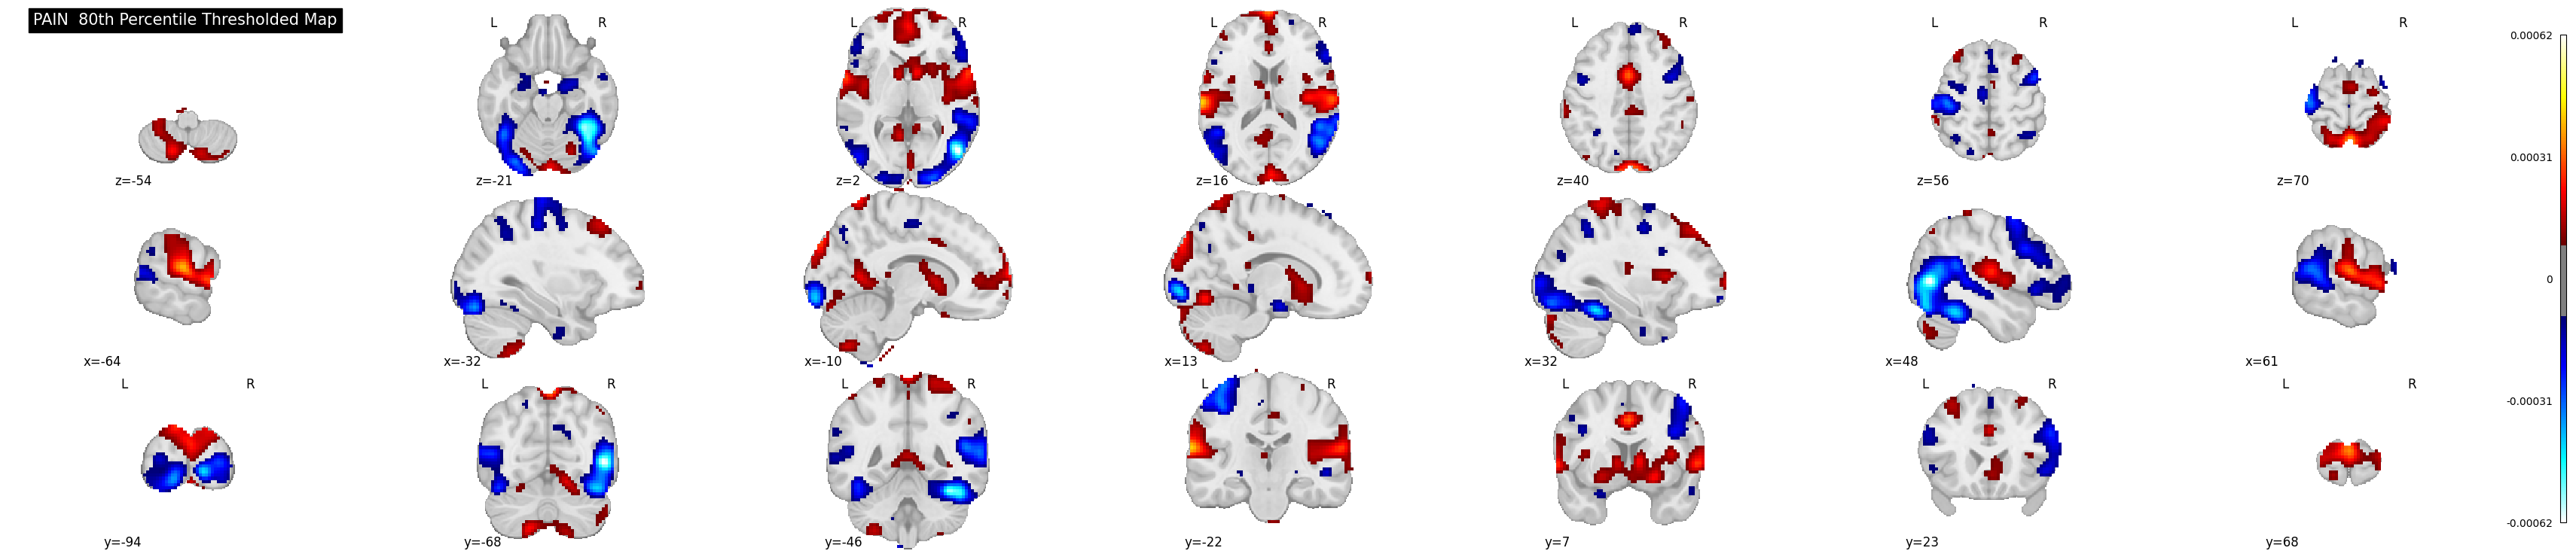

In [192]:
pain = nifti_masker.inverse_transform(coefficients[0][0,:])
data = pain.get_fdata()
percentile_90 = np.percentile(data[data != 0], 90)  # Exclude zero or background voxels if necessary

plotting.plot_stat_map(pain, threshold=percentile_90,
                       display_mode='mosaic',
             title='PAIN  90th Percentile Thresholded Map')

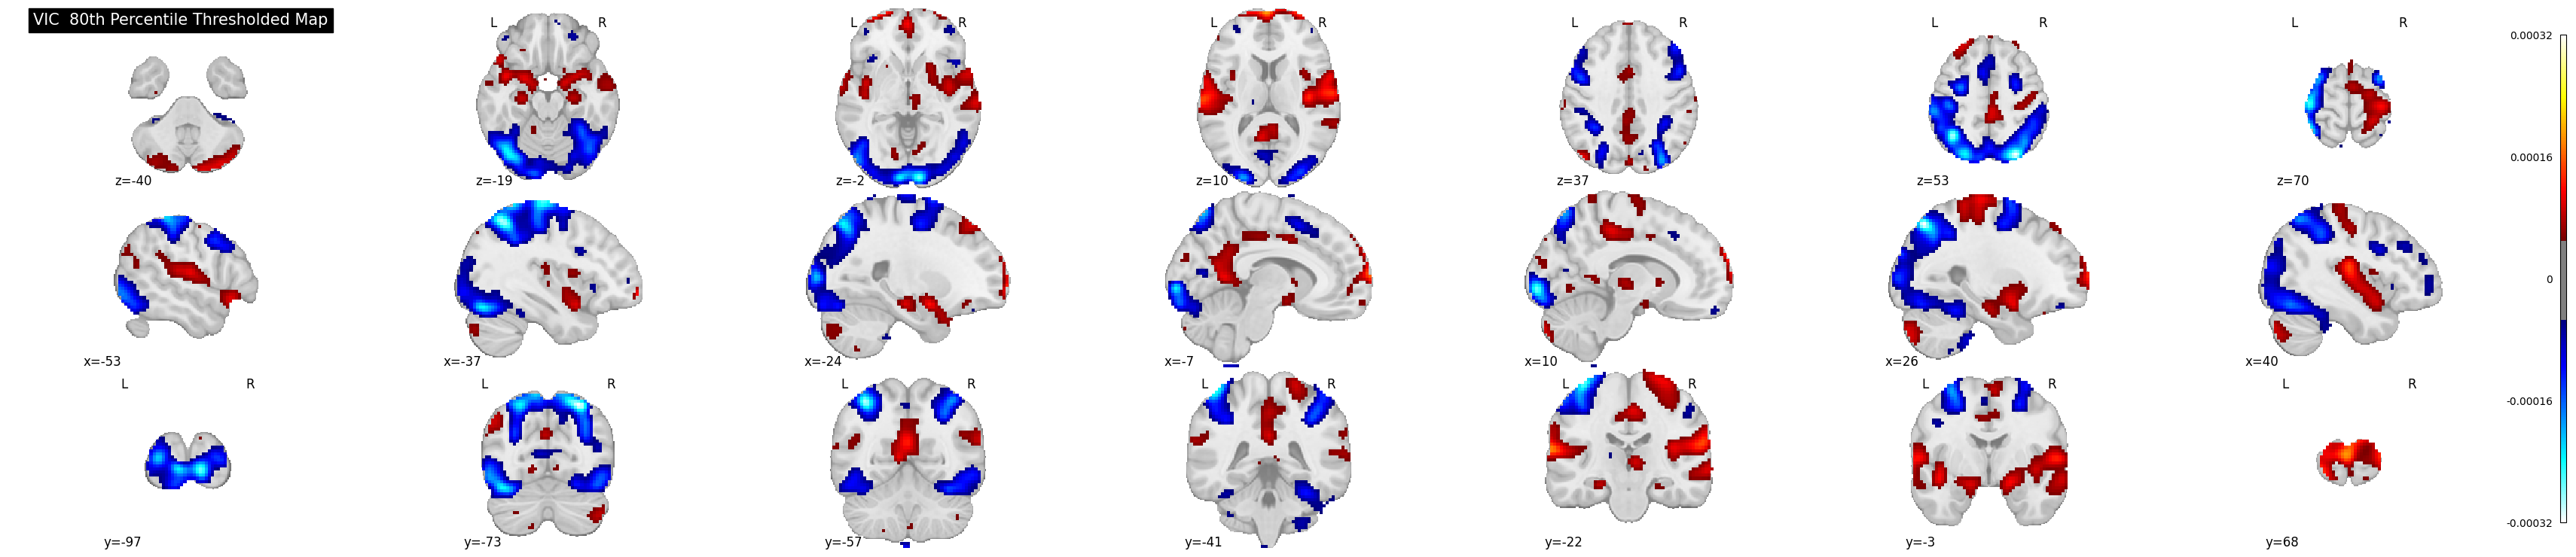

In [193]:
vic = nifti_masker.inverse_transform(mean_array[1,:])
data = vic.get_fdata()
percentile_90 = np.percentile(data[data != 0], 90)  # Exclude zero or background voxels if necessary

plotting.plot_stat_map(vic, threshold=percentile_90,
                       display_mode='mosaic',
             title='VIC  90th Percentile Thresholded Map')

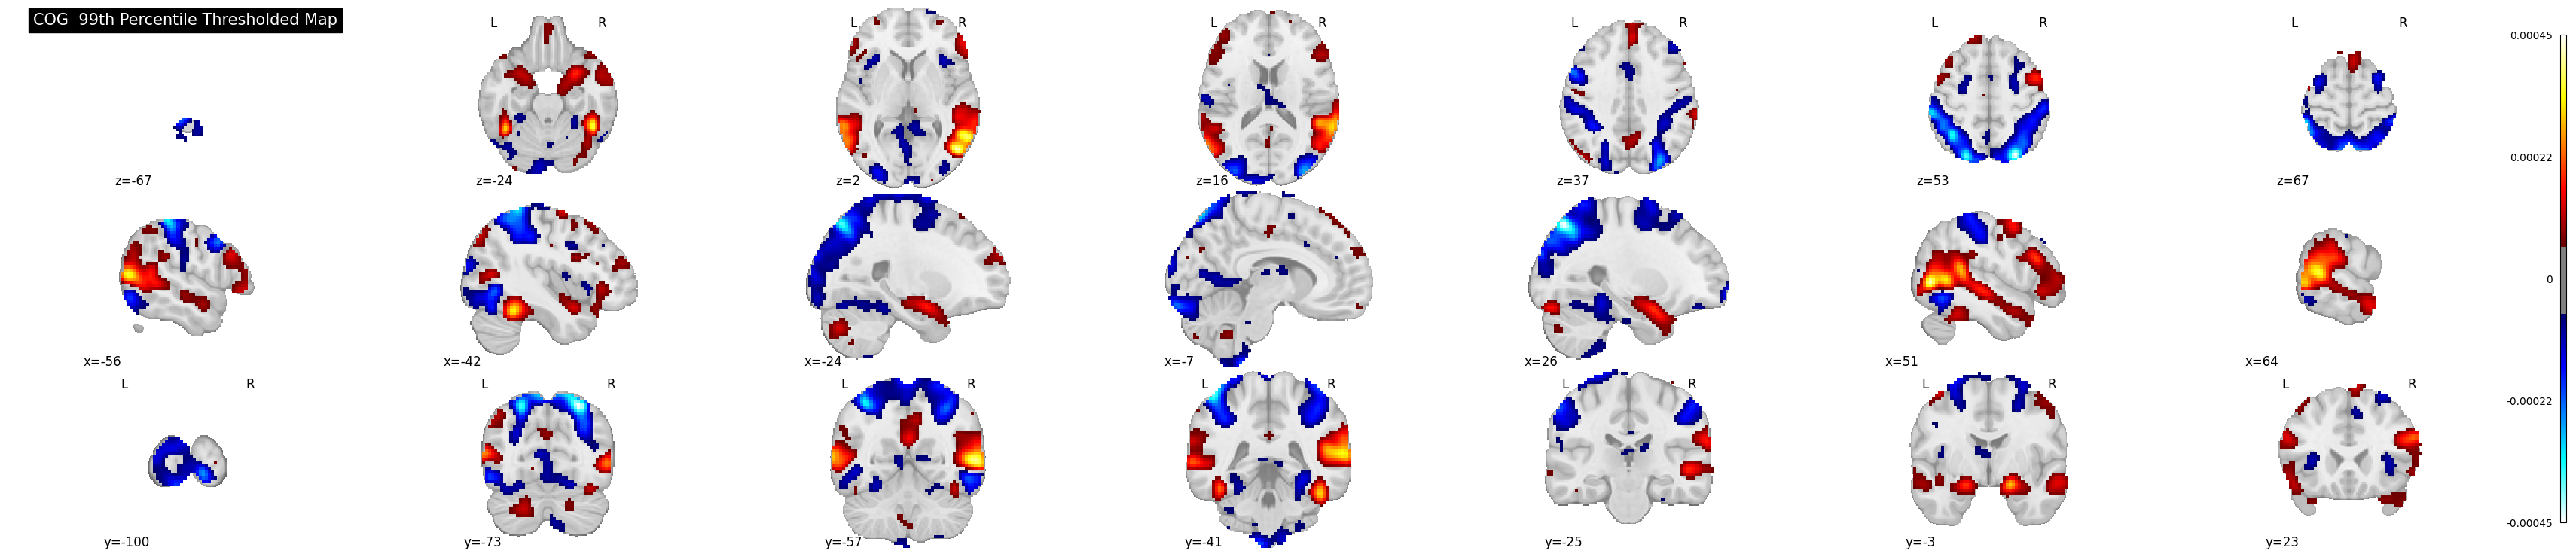

In [194]:
cog = nifti_masker.inverse_transform(mean_array[2,:])
data = cog.get_fdata()
percentile_90 = np.percentile(data[data != 0], 90)  # Exclude zero or background voxels if necessary
plotting.plot_stat_map(cog, threshold=percentile_90,
                    display_mode='mosaic',   
             title='COG  90th Percentile Thresholded Map')

## confusion matrix

/dartfs-hpc/rc/home/1/f0042x1/.conda/envs/spacetop_env/lib/python3.7/site-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function plot_confusion_matrix is deprecated; Function `plot_confusion_matrix` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: ConfusionMatrixDisplay.from_predictions or ConfusionMatrixDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)


<Figure size 800x600 with 0 Axes>

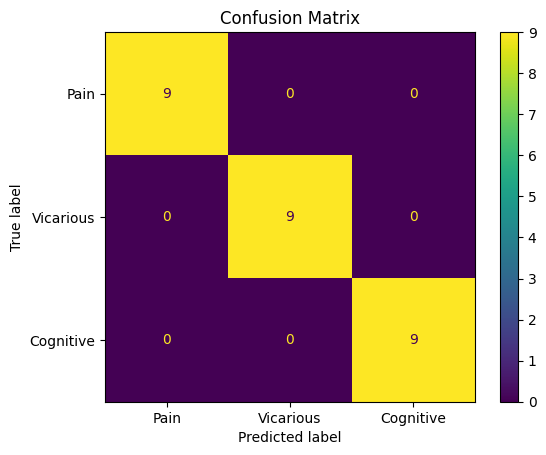

Confusion Matrix:
[[9 0 0]
 [0 9 0]
 [0 0 9]]


In [142]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.svm import SVC
from sklearn.metrics import confusion_matrix, plot_confusion_matrix
from sklearn.model_selection import train_test_split

# # Assuming you have X (brain data) and Y (labels)
# # X should be of shape (number of trials, number of voxels)
# # Y should be a 1D array with labels (0 for pain, 1 for vicarious, 2 for cognitive)

# # Split your data into training and testing sets
# X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.2, random_state=42)

# # Initialize and train a Support Vector Machine (SVM) classifier
# svm = SVC(kernel='linear', decision_function_shape='ovr')  # One-vs-Rest
# svm.fit(X_train, Y_train)

# # Get the predictions on the test set
# Y_pred = svm.predict(X_test)

# Calculate the confusion matrix
conf_matrix = confusion_matrix(Y_test, Y_pred)

# Plot the confusion matrix
plt.figure(figsize=(8, 6))
plot_confusion_matrix(svm, X_test, Y_test, display_labels=['Pain', 'Vicarious', 'Cognitive'])
plt.title('Confusion Matrix')
plt.show()

print('Confusion Matrix:')
print(conf_matrix)


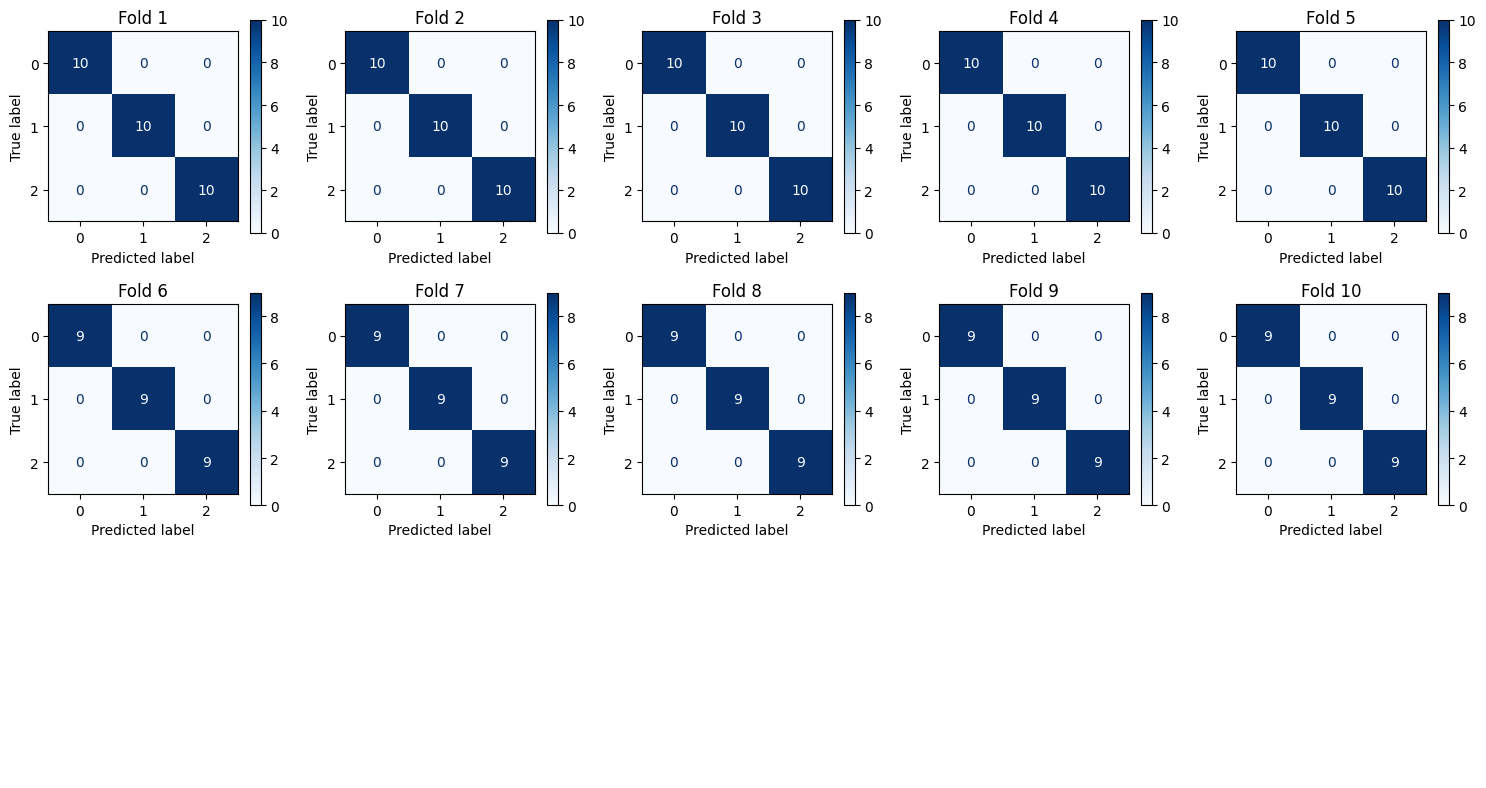

In [203]:
num_folds = len(confusion_matrices)

# Create subplots with a grid layout (e.g., 2 rows and 5 columns for 10 folds)
fig, axes = plt.subplots(num_folds // 5 + 1, 5, figsize=(15, 8))

for i, ax in enumerate(axes.flatten()):
    if i < num_folds:
        cm = confusion_matrices[i]
        disp = ConfusionMatrixDisplay(confusion_matrix=cm)
        disp.plot(ax=ax, cmap='Blues', values_format='d')
        ax.set_title(f'Fold {i + 1}')
    else:
        ax.axis('off')

plt.tight_layout()
plt.show()


In [145]:
from sklearn import svm
# from sklearn.inspection import DecisionBoundaryDisplay
y = Y

def plot_training_data_with_decision_boundary(kernel):
    # Train the SVC
    clf = svm.SVC(kernel=kernel, gamma=2).fit(X, y)

    # Settings for plotting
    _, ax = plt.subplots(figsize=(4, 3))
    x_min, x_max, y_min, y_max = -3, 3, -3, 3
    ax.set(xlim=(x_min, x_max), ylim=(y_min, y_max))

    # Plot decision boundary and margins
    common_params = {"estimator": clf, "X": X, "ax": ax}
    DecisionBoundaryDisplay.from_estimator(
        **common_params,
        response_method="predict",
        plot_method="pcolormesh",
        alpha=0.3,
    )
    DecisionBoundaryDisplay.from_estimator(
        **common_params,
        response_method="decision_function",
        plot_method="contour",
        levels=[-1, 0, 1],
        colors=["k", "k", "k"],
        linestyles=["--", "-", "--"],
    )

    # Plot bigger circles around samples that serve as support vectors
    ax.scatter(
        clf.support_vectors_[:, 0],
        clf.support_vectors_[:, 1],
        s=250,
        facecolors="none",
        edgecolors="k",
    )
    # Plot samples by color and add legend
    ax.scatter(X[:, 0], X[:, 1], c=y, s=150, edgecolors="k")
    ax.legend(*scatter.legend_elements(), loc="upper right", title="Classes")
    ax.set_title(f" Decision boundaries of {kernel} kernel in SVC")

    _ = plt.show()

In [ ]:
from sklearn.model_selection import permutation_test_score

null_cv_scores = permutation_test_score(
    svm, X, Y, cv=crossval, groups=group
)[1]
print(f"Permutation test score: {null_cv_scores.mean():.3f}")

# visualization

https://scikit-learn.org/stable/auto_examples/svm/plot_svm_kernels.html#sphx-glr-auto-examples-svm-plot-svm-kernels-py

In [49]:
X

array([[ 0.2561621 ,  0.75933635,  0.84805375, ...,  0.87237346,
         0.7765289 ,  0.8318939 ],
       [ 0.02101815, -0.17371492, -0.18595462, ..., -0.17266287,
        -0.30860853, -0.16461676],
       [-0.19144183,  0.12329094,  0.01234423, ..., -0.18597525,
        -0.31628698, -0.1409902 ],
       ...,
       [-0.14118963,  0.11523844,  0.17972404, ..., -0.03876969,
        -0.04574591, -0.01567423],
       [ 0.0062924 ,  0.11212283,  0.08402707, ..., -0.06554338,
        -0.16298726, -0.1842334 ],
       [-0.26077867, -0.8010036 , -1.0114617 , ..., -0.29918095,
        -0.32342917, -0.28137654]], dtype=float32)

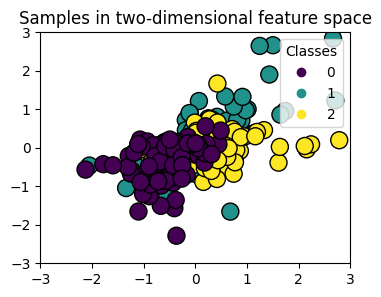

/dartfs-hpc/rc/home/1/f0042x1/.conda/envs/spacetop_env/lib/python3.7/site-packages/sklearn/model_selection/_validation.py:774: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/dartfs-hpc/rc/home/1/f0042x1/.conda/envs/spacetop_env/lib/python3.7/site-packages/sklearn/model_selection/_validation.py", line 761, in _score
    scores = scorer(estimator, X_test, y_test)
  File "/dartfs-hpc/rc/home/1/f0042x1/.conda/envs/spacetop_env/lib/python3.7/site-packages/sklearn/metrics/_scorer.py", line 103, in __call__
    score = scorer._score(cached_call, estimator, *args, **kwargs)
  File "/dartfs-hpc/rc/home/1/f0042x1/.conda/envs/spacetop_env/lib/python3.7/site-packages/sklearn/metrics/_scorer.py", line 349, in _score
    raise ValueError("{0} format is not supported".format(y_type))
ValueError: multiclass format is not supported

  UserWarning,
/dartfs-hpc/rc/home/1/f0042x1/.conda/envs

/dartfs-hpc/rc/home/1/f0042x1/.conda/envs/spacetop_env/lib/python3.7/site-packages/sklearn/model_selection/_validation.py:774: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/dartfs-hpc/rc/home/1/f0042x1/.conda/envs/spacetop_env/lib/python3.7/site-packages/sklearn/model_selection/_validation.py", line 761, in _score
    scores = scorer(estimator, X_test, y_test)
  File "/dartfs-hpc/rc/home/1/f0042x1/.conda/envs/spacetop_env/lib/python3.7/site-packages/sklearn/metrics/_scorer.py", line 103, in __call__
    score = scorer._score(cached_call, estimator, *args, **kwargs)
  File "/dartfs-hpc/rc/home/1/f0042x1/.conda/envs/spacetop_env/lib/python3.7/site-packages/sklearn/metrics/_scorer.py", line 349, in _score
    raise ValueError("{0} format is not supported".format(y_type))
ValueError: multiclass format is not supported

  UserWarning,


In [90]:
# Plotting settings
fig, ax = plt.subplots(figsize=(4, 3))
x_min, x_max, y_min, y_max = -3, 3, -3, 3
ax.set(xlim=(x_min, x_max), ylim=(y_min, y_max))

# Plot samples by color and add legend
scatter = ax.scatter(X[:, 0], X[:, 1], s=150, c=Y, label=Y, edgecolors="k")
ax.legend(*scatter.legend_elements(), loc="upper right", title="Classes")
ax.set_title("Samples in two-dimensional feature space")
_ = plt.show()

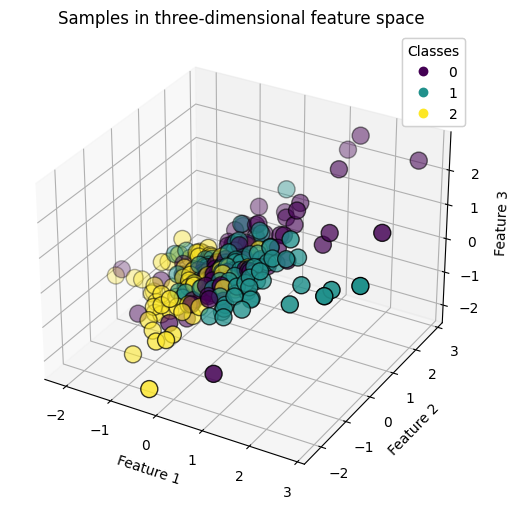

In [219]:
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D  # Import the 3D plotting module

# Create a 3D figure
fig = plt.figure(figsize=(8, 6))
ax = fig.add_subplot(111, projection='3d')

# Plot samples in three-dimensional feature space
scatter = ax.scatter(X[:, 0], X[:, 1], X[:, 2], s=150, c=Y, edgecolors="k")

# Add legend
legend = ax.legend(*scatter.legend_elements(), loc="upper right", title="Classes")
ax.add_artist(legend)

# Set labels for the axes
ax.set_xlabel('Feature 1')
ax.set_ylabel('Feature 2')
ax.set_zlabel('Feature 3')

# Set title
ax.set_title("Samples in three-dimensional feature space")

plt.show()


## decision boundary - work in progress

In [98]:
def plot_contours(ax, clf, xx, yy, **params):
    Z = clf.predict(np.c_[xx.ravel(), yy.ravel()])
    Z = Z.reshape(xx.shape)
    out = ax.contourf(xx, yy, Z, **params)
    return out

def make_meshgrid(x, y, h=.02):
    x_min, x_max = x.min() - 1, x.max() + 1
    y_min, y_max = y.min() - 1, y.max() + 1
    xx, yy = np.meshgrid(np.arange(x_min, x_max, h), np.arange(y_min, y_max, h))
    return xx, yy

In [147]:
# Import the required libraries
import matplotlib.pyplot as plt
import numpy as np
from sklearn.datasets import load_iris
from sklearn.tree import DecisionTreeClassifier

# Create some example data
iris = load_iris()
feature_1, feature_2 = np.meshgrid(
    np.linspace(iris.data[:, 0].min(), iris.data[:, 0].max()),
    np.linspace(iris.data[:, 1].min(), iris.data[:, 1].max())
)
grid = np.vstack([feature_1.ravel(), feature_2.ravel()]).T
tree = DecisionTreeClassifier().fit(iris.data[:, :2], iris.target)
y_pred = np.reshape(tree.predict(grid), feature_1.shape)

# Create a DecisionBoundaryDisplay object
display = DecisionBoundaryDisplay(
    xx0=feature_1, xx1=feature_2, response=y_pred
)

# Plot the decision boundary
display.plot()

# You can also add additional elements to the plot, such as scatter points
display.ax_.scatter(
    iris.data[:, 0], iris.data[:, 1], c=iris.target, edgecolor="black"
)

# Show the plot
plt.show()


NameError: name 'DecisionBoundaryDisplay' is not defined

In [149]:
pip install -U scikit-learn --user

Note: you may need to restart the kernel to use updated packages.


In [148]:
import matplotlib.pyplot as plt
import numpy as np
from sklearn.datasets import load_iris
from sklearn.inspection import DecisionBoundaryDisplay
from sklearn.tree import DecisionTreeClassifier
iris = load_iris()
feature_1, feature_2 = np.meshgrid(
    np.linspace(iris.data[:, 0].min(), iris.data[:, 0].max()),
    np.linspace(iris.data[:, 1].min(), iris.data[:, 1].max())
)
grid = np.vstack([feature_1.ravel(), feature_2.ravel()]).T
tree = DecisionTreeClassifier().fit(iris.data[:, :2], iris.target)
y_pred = np.reshape(tree.predict(grid), feature_1.shape)
display = DecisionBoundaryDisplay(
    xx0=feature_1, xx1=feature_2, response=y_pred
)
display.plot()
display.ax_.scatter(
    iris.data[:, 0], iris.data[:, 1], c=iris.target, edgecolor="black"
)
plt.show()

ImportError: cannot import name 'DecisionBoundaryDisplay' from 'sklearn.inspection' (/dartfs-hpc/rc/home/1/f0042x1/.conda/envs/spacetop_env/lib/python3.7/site-packages/sklearn/inspection/__init__.py)

In [102]:
print("Shape of X:", X.shape)
print("Shape of X_train:", X_train.shape)


Shape of X: (285, 98053)
Shape of X_train: (255, 98053)


## ROC curve

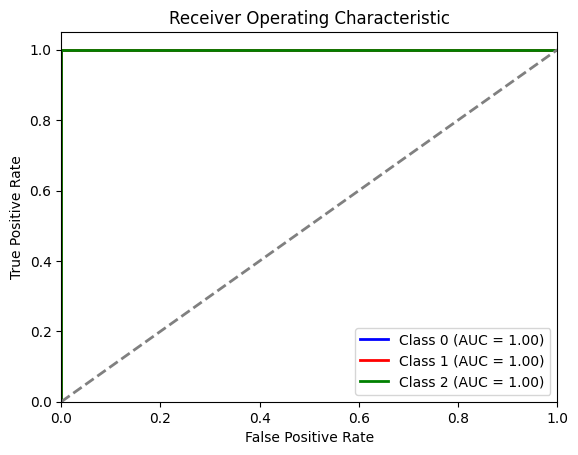

In [206]:
from sklearn.metrics import roc_curve, auc
import matplotlib.pyplot as plt

# Assuming Y_test and Y_pred are the true labels and predicted labels
fpr = dict()
tpr = dict()
roc_auc = dict()
num_classes = 3
classes = ['p', 'v', 'c']
# Calculate ROC curve and AUC for each class
# for i in range(num_classes):
# for i, class_name in enumerate(classes):
for i in range(num_classes):
    fpr[i], tpr[i], _ = roc_curve(Y_test == i, Y_pred == i)
    roc_auc[i] = auc(fpr[i], tpr[i])

# Plot ROC curves for each class
plt.figure()
colors = ['blue', 'red', 'green']  # Adjust colors as needed
for i in range(num_classes):
    plt.plot(fpr[i], tpr[i], color=colors[i], lw=2, label=f'Class {i} (AUC = {roc_auc[i]:.2f})')

plt.plot([0, 1], [0, 1], color='gray', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic')
plt.legend(loc='lower right')
plt.show()


In [212]:
Y_test

array([0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 2, 2, 2, 2,
       2, 2, 2, 2, 2])

In [213]:
Y_pred

array([0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 2, 2, 2, 2,
       2, 2, 2, 2, 2])

In [215]:
for i in range(num_classes):
    fpr[i], tpr[i], _ = roc_curve(Y_test == i, Y_pred == i)
    roc_auc[i] = auc(fpr[i], tpr[i])

In [216]:
roc_auc

{0: 1.0, 1: 1.0, 2: 1.0}

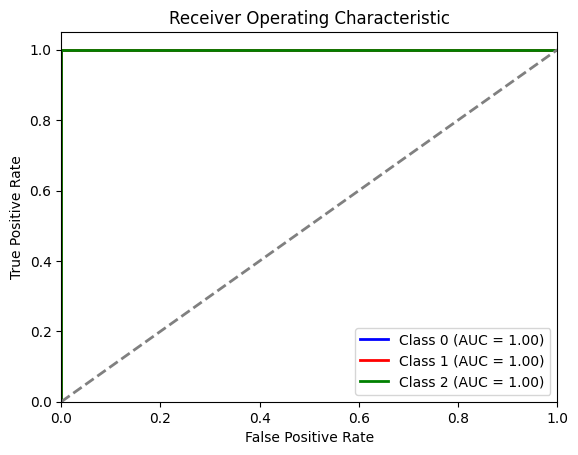

In [218]:
from sklearn.metrics import roc_curve, auc
import matplotlib.pyplot as plt

# Assuming Y_test and Y_pred are the true labels and predicted labels
fpr = dict()
tpr = dict()
roc_auc = dict()
num_classes = 3

# Calculate ROC curve and AUC for each class
for i in range(num_classes):
    fpr[i], tpr[i], _ = roc_curve(Y_test == i, Y_pred == i)
    roc_auc[i] = auc(fpr[i], tpr[i])

# Plot ROC curves for each class
plt.figure()
colors = ['blue', 'red', 'green']  # Adjust colors as needed
for i in range(num_classes):
    plt.plot(fpr[i], tpr[i], color=colors[i], lw=2, label=f'Class {i} (AUC = {roc_auc[i]:.2f})')

plt.plot([0, 1], [0, 1], color='gray', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic')
plt.legend(loc='lower right')
plt.show()


In [44]:
import numpy as np

# Add jitter to Y_pred for visualization
jitter = np.random.uniform(-0.1, 0.1, size=len(Y_pred))
Y_pred_jittered = Y_pred + jitter

plt.scatter(Y, Y_pred_jittered, alpha=0.5)
plt.xlabel('True Labels (Y)')
plt.ylabel('Predicted Labels (Y_pred)')
plt.title('True vs. Predicted Labels')
plt.show()


UFuncTypeError: ufunc 'add' did not contain a loop with signature matching types (dtype('<U1'), dtype('float64')) -> None